In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_harmonic = pd.read_excel("datasets/df_harmonic.xlsx")

## Partie 1

### PARTIE 1 : PRÉPARATION DES DONNÉES HARMONIQUES

In [42]:
def prepare_harmonic_data_tda(df_harmonic, features=None, sample_size=3000):
    """
    Prépare les données harmoniques pour l'analyse TDA - Version optimisée
    """
    print("🎼 === PRÉPARATION DES DONNÉES POUR TDA HARMONIQUE ===")
    
    # Features harmoniques optimales pour TDA
    if features is None:
        features = ['pitch', 'local_key', 'key', 'is_chord_tone', 'interval_to_prev']
    
    # Nettoyage et vérification
    available_features = [f for f in features if f in df_harmonic.columns]
    print(f"✅ Features utilisées: {available_features}")
    
    # Suppression des valeurs manquantes et infinies
    df_clean = df_harmonic[available_features].replace([np.inf, -np.inf], np.nan).dropna()
    
    # Échantillonnage stratifié par pitch pour garder la diversité harmonique
    if len(df_clean) > sample_size:
        # Échantillonnage par quantiles de pitch pour préserver la diversité
        df_clean['pitch_bin'] = pd.qcut(df_clean['pitch'], q=10, duplicates='drop')
        df_sample = df_clean.groupby('pitch_bin').apply(
            lambda x: x.sample(min(len(x), sample_size//10), random_state=42)
        ).reset_index(drop=True)
        df_sample = df_sample.drop('pitch_bin', axis=1)[:sample_size]
    else:
        df_sample = df_clean.copy()
    
    print(f"📊 Dataset final: {len(df_sample):,} observations")
    
    # Normalisation robuste
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sample[available_features])
    
    # Vérification de la qualité des données
    print(f"📈 Statistiques:")
    print(f"   • Variance expliquée par PC1: {PCA(n_components=1).fit(X_scaled).explained_variance_ratio_[0]:.3f}")
    print(f"   • Plage de hauteurs: {df_sample['pitch'].min():.0f} - {df_sample['pitch'].max():.0f}")
    
    return X_scaled, df_sample, available_features, scaler

### TESTS ET FONCTIONS D'AIDE

In [43]:
def test_data_quality(X_scaled, df_sample):
    """Tests de qualité des données"""
    
    print(f"\n🔎 === TESTS DE QUALITÉ ===")
    
    # Tests basiques
    has_nan = np.isnan(X_scaled).any()
    has_inf = np.isinf(X_scaled).any()
    
    print(f"   • Valeurs manquantes: {'❌ OUI' if has_nan else '✅ NON'}")
    print(f"   • Valeurs infinies: {'❌ OUI' if has_inf else '✅ NON'}")
    print(f"   • Shape finale: {X_scaled.shape}")
    print(f"   • Variance moyenne: {np.var(X_scaled, axis=0).mean():.3f}")
    
    # Distribution après normalisation
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.boxplot(X_scaled, labels=[f'F{i}' for i in range(X_scaled.shape[1])])
    plt.title('Distribution des features normalisées')
    plt.ylabel('Valeurs standardisées')
    
    plt.subplot(1, 3, 2)
    plt.hist(X_scaled.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution globale après normalisation')
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    
    plt.subplot(1, 3, 3)
    distances = np.sqrt(np.sum(X_scaled**2, axis=1))
    plt.hist(distances, bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution des distances à l\'origine')
    plt.xlabel('Distance euclidienne')
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()
    
    quality_score = 1.0
    if has_nan: quality_score -= 0.5
    if has_inf: quality_score -= 0.3
    if X_scaled.shape[0] < 100: quality_score -= 0.2
    
    print(f"\n📊 Score de qualité: {quality_score:.1f}/1.0")
    
    return quality_score > 0.7

def run_part1_harmonic_preparation(df_harmonic, features=None, sample_size=5000):
    """
    FONCTION PRINCIPALE PARTIE 1
    Prépare et analyse les données harmoniques
    """
    
    print("🎼" + "="*60)
    print("   PARTIE 1: PRÉPARATION DES DONNÉES HARMONIQUES")
    print("="*64)
    
    # 1. Préparation des données
    X_scaled, df_sample, feature_names, scaler = prepare_harmonic_data(
        df_harmonic, features, sample_size
    )
    
    # 2. Aperçu rapide
    corr_matrix = quick_harmonic_overview(df_sample, feature_names)
    
    # 3. Tests de qualité
    is_good_quality = test_data_quality(X_scaled, df_sample)
    
    # 4. Résultats
    results_part1 = {
        'X_scaled': X_scaled,
        'df_sample': df_sample, 
        'feature_names': feature_names,
        'scaler': scaler,
        'correlations': corr_matrix,
        'quality_ok': is_good_quality,
        'n_samples': len(df_sample),
        'n_features': len(feature_names)
    }
    
    print(f"\n✅ === PARTIE 1 TERMINÉE ===")
    print(f"   • {len(df_sample):,} observations préparées")
    print(f"   • {len(feature_names)} features harmoniques")
    print(f"   • Qualité: {'✅ OK' if is_good_quality else '⚠️  À surveiller'}")
    print(f"   • Prêt pour la Partie 2 (visualisation)")
    
    return results_part1

### UTILISATION PARTIE 1

In [44]:
# Exemple d'utilisation:
# results_part1 = run_part1_harmonic_preparation(df_harmonic)

print("\n🎼 === CODE PARTIE 1 PRÊT ===")
print("Utilisez: results_part1 = run_part1_harmonic_preparation(df_harmonic)")
print("\nCette partie va:")
print("• Nettoyer et normaliser vos données harmoniques") 
print("• Faire un aperçu des corrélations et distributions")
print("• Tester la qualité des données")
print("• Préparer tout pour la Partie 2")


🎼 === CODE PARTIE 1 PRÊT ===
Utilisez: results_part1 = run_part1_harmonic_preparation(df_harmonic)

Cette partie va:
• Nettoyer et normaliser vos données harmoniques
• Faire un aperçu des corrélations et distributions
• Tester la qualité des données
• Préparer tout pour la Partie 2


🎼============================================================
   PARTIE 1: PRÉPARATION DES DONNÉES HARMONIQUES
🎼 === PARTIE 1: PRÉPARATION DES DONNÉES HARMONIQUES ===
✅ Features utilisées: ['pitch', 'local_key', 'key', 'is_chord_tone', 'interval_to_prev', 'pitch_octave']
📊 Échantillonnage: 5,000 sur 139,306 observations

📈 APERÇU DES DONNÉES:
   • Plage de hauteurs: 24 - 106
   • Tonalités uniques: 18
   • Notes d'accord: 66.6%
   • Intervalle médian: 5 demi-tons

🔍 === APERÇU RAPIDE DE L'ESPACE HARMONIQUE ===


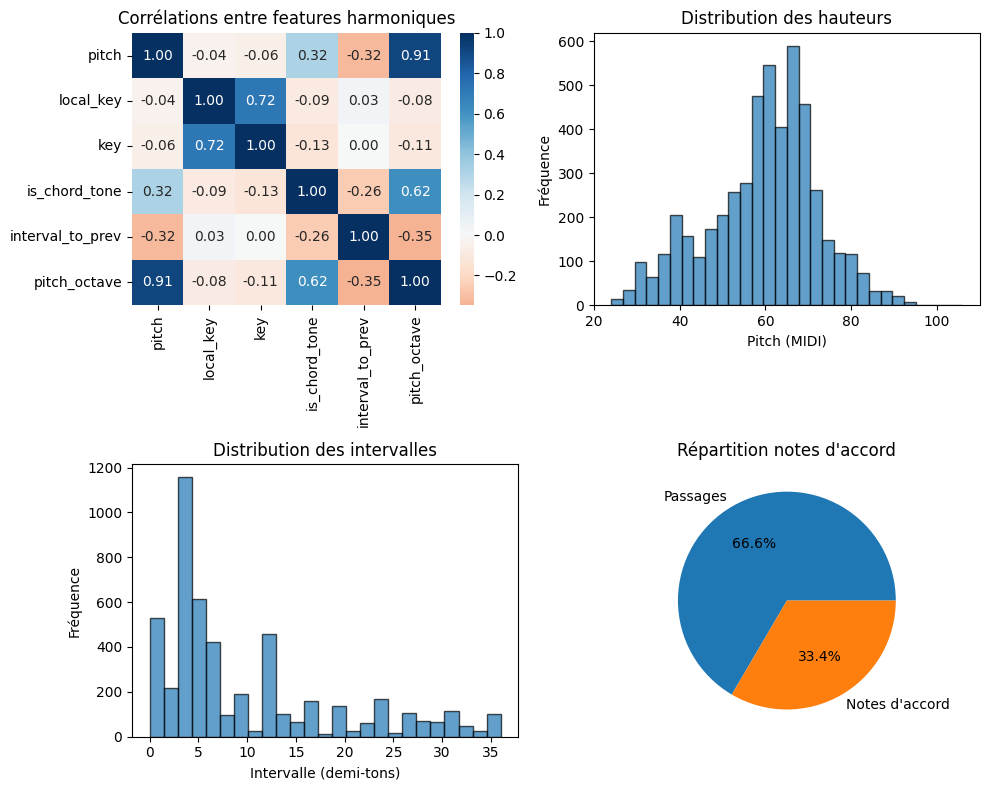


🔎 === TESTS DE QUALITÉ ===
   • Valeurs manquantes: ✅ NON
   • Valeurs infinies: ✅ NON
   • Shape finale: (5000, 6)
   • Variance moyenne: 1.000


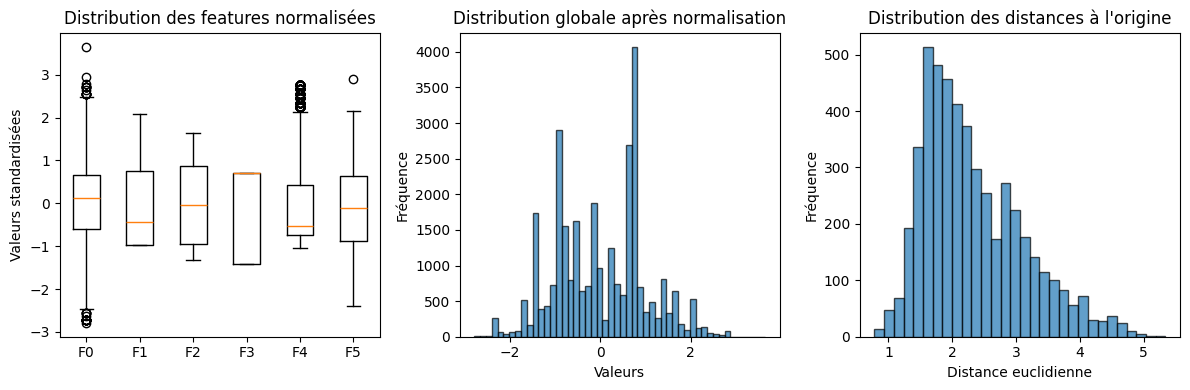


📊 Score de qualité: 1.0/1.0

✅ === PARTIE 1 TERMINÉE ===
   • 5,000 observations préparées
   • 6 features harmoniques
   • Qualité: ✅ OK
   • Prêt pour la Partie 2 (visualisation)


In [45]:
results_part1 = run_part1_harmonic_preparation(df_harmonic)

## Nouvelle partie

In [46]:
class TDAHarmonicAnalysis:
    """
    Pipeline hybride pour analyse TDA harmonique :
    - Persistance H0 exacte via MST 
    - DBSCAN optimisé avec paramètres rigoureux
    - Analyse comparative et visualisations
    """
    
    def __init__(self, X_scaled, df_sample, available_features, scaler):
        self.X_scaled = X_scaled
        self.df_sample = df_sample
        self.available_features = available_features
        self.scaler = scaler
        self.n_samples, self.n_features = X_scaled.shape
        
        # Résultats stockés
        self.pca_result = None
        self.h0_persistence = None
        self.dbscan_result = None
        self.mst_tree = None
        
    def compute_effective_dimension(self, variance_threshold=0.95):
        # 1. Vérification de sécurité : éviter NaN / Inf
        if not np.all(np.isfinite(self.X_scaled)):
            bad = np.argwhere(~np.isfinite(self.X_scaled))
            raise ValueError(
                f"[PCA] X_scaled contient des valeurs non finies (NaN/Inf). "
                f"Première occurrence à l’index {bad[0].tolist()}."
            )
        # 2. Normalisation du seuil
        variance_threshold = float(np.clip(variance_threshold, 0.0, 0.999999))

        # 3. Nombre max de composantes autorisé
        target = min(self.n_features, self.n_samples - 1)

        # 4. PCA réduite pour la visu
        n_components = max(1, min(20, target))
        pca = PCA(n_components=n_components, random_state=42)
        X_pca = pca.fit_transform(self.X_scaled)
        cumvar = np.cumsum(pca.explained_variance_ratio_)

        # 5. Si variance pas atteinte → PCA complète
        if cumvar[-1] < variance_threshold and n_components < target:
            pca_full = PCA(n_components=target, random_state=42)
            X_pca_full = pca_full.fit_transform(self.X_scaled)
            cumvar_full = np.cumsum(pca_full.explained_variance_ratio_)
            eff_dim = int(np.searchsorted(cumvar_full, variance_threshold) + 1)
            self.pca_result = {
                'pca': pca,
                'X_transformed': X_pca,
                'effective_dim': eff_dim,
                'cumulative_variance': cumvar_full,
                'explained_variance_ratio': pca_full.explained_variance_ratio_
            }
        else:
            eff_dim = int(np.searchsorted(cumvar, variance_threshold) + 1)
            self.pca_result = {
                'pca': pca,
                'X_transformed': X_pca,
                'effective_dim': eff_dim,
                'cumulative_variance': cumvar,
                'explained_variance_ratio': pca.explained_variance_ratio_
            }
        print(f"Dimension effective ({variance_threshold:.0%} variance): {eff_dim}/{self.n_features}")
        return eff_dim
    
    
    def compute_h0_persistence_mst(self, k_neighbors=10):
        """
        Calcule la vraie persistance H0 via MST sur graphe k-NN creux
        - Scalable : O(kn log n) vs O(n²)
        - Toutes les barres H0 naissent à ε=0 (Vietoris-Rips)
        """
        print("Calcul de la persistance H0 exacte via MST k-NN...")
        
        def build_connected_knn_graph(k):
            """Construit graphe k-NN symétrisé et vérifie connexité"""
            G = kneighbors_graph(self.X_scaled, n_neighbors=k, 
                               mode='distance', metric='euclidean', include_self=False)
            
            # Symétrisé 
            W = G.maximum(G.T)
            
            # Vérification de connexité
            n_components, _ = connected_components(W, directed=False)
            is_connected = (n_components == 1)
            
            return W, is_connected, n_components
        
        # Recherche k pour assurer connexité
        k_candidates = [k_neighbors, 20, 40, min(80, self.n_samples - 1)]
        connected_graph = None
        final_k = None
        
        for k in k_candidates:
            if k >= self.n_samples:
                break
            try:
                W, is_connected, n_comp = build_connected_knn_graph(k)
                print(f"  k={k}: {n_comp} composante(s)")
                if is_connected:
                    connected_graph = W
                    final_k = k
                    break
            except Exception as e:
                print(f"  k={k}: erreur ({e})")
                continue

        # >>> Fallback ici <<<
        if connected_graph is None:
            # Fallback dense seulement pour petits n (sinon O(n^2) trop coûteux)
            if self.n_samples <= 3000:
                print(f"  ⚠️ Graphe k-NN non connexe pour k ≤ {k_candidates[-1]}, fallback MST dense (petit n)")
                from scipy.spatial.distance import pdist, squareform
                D = squareform(pdist(self.X_scaled, metric='euclidean'))
                connected_graph = csr_matrix(D)
                final_k = None  # on documente le fallback
            else:
                raise RuntimeError(
                    f"Impossible d'obtenir un graphe connexe avec k ≤ {k_candidates[-1]} "
                    f"et fallback dense interdit (n={self.n_samples} trop grand)"
                )

        print(f"  Graphe connexe obtenu avec {'k='+str(final_k) if final_k is not None else 'fallback dense'}")
        
        # MST sur le graphe k-NN creux
        mst = minimum_spanning_tree(connected_graph).tocoo()
        self.mst_tree = mst  
        
        # Extraction des arêtes MST non-nulles
        mst_edges = [(i, j, float(w)) for i, j, w in zip(mst.row, mst.col, mst.data)]
        
        # Tri par poids croissant pour filtration
        mst_edges.sort(key=lambda x: x[2])
        
        # Calcul persistance H0 - TOUTES naissent à ε=0
        birth_death_pairs = []
        
        # Union-Find
        parent = list(range(self.n_samples))
        
        def find(x):
            if parent[x] != x:
                parent[x] = find(parent[x])
            return parent[x]
        
        def union(x, y):
            px, py = find(x), find(y)
            if px != py:
                parent[px] = py
                return True
            return False
        
        # Filtration : ajout arêtes par poids croissant
        for i, j, weight in mst_edges:
            if union(i, j):
                # Mort d'une composante : (naissance=0, mort=weight)
                birth_death_pairs.append((0.0, weight))
        
        # La dernière composante survit jusqu'à l'infini
        max_weight = mst_edges[-1][2] if mst_edges else 0
        birth_death_pairs.append((0.0, np.inf))
        
        self.h0_persistence = {
            'birth_death_pairs': birth_death_pairs,
            'mst_edges': mst_edges,
            'final_k': final_k,
            'max_epsilon': max_weight
        }
        
        n_finite = len([p for p in birth_death_pairs if p[1] != np.inf])
        print(f"Persistance H0: {n_finite} morts + 1 survivante")
        return birth_death_pairs
    
    def optimize_dbscan_parameters(self):
        """
        Optimisation rigoureuse des paramètres DBSCAN avec garde-fous
        - eps via k-distance avec plancher anti-doublons
        - min_samples borné par taille échantillon
        """
        print("Optimisation des paramètres DBSCAN...")
        
        if self.pca_result is None:
            self.compute_effective_dimension()
        
        eff_dim = self.pca_result['effective_dim']
        
        # min_samples avec garde-fou
        min_samples = max(2, 2 * eff_dim)
        min_samples = min(min_samples, self.n_samples - 1)  # Borne haute
        print(f"min_samples choisi : {min_samples} (2×{eff_dim}, borné par n-1)")
        
        # k-distance pour eps avec métrique explicite
        nbrs = NearestNeighbors(n_neighbors=min_samples, metric='euclidean')
        nbrs.fit(self.X_scaled)
        distances, indices = nbrs.kneighbors(self.X_scaled)
        
        # Distance au k-ème voisin
        k_distances = distances[:, -1]
        
        # Percentiles avec plancher anti-doublons
        eps_candidates = [
            np.percentile(k_distances, 85),
            np.percentile(k_distances, 90),
            np.percentile(k_distances, 95)
        ]
        
        # Plancher pour éviter eps=0 (doublons/quantification)
        eps_floor = 1e-8
        eps_candidates = [max(eps, eps_floor) for eps in eps_candidates]
        
        print(f"k-distances: min={np.min(k_distances):.6f}, max={np.max(k_distances):.6f}")
        print(f"Candidats eps (85,90,95 percentiles + plancher): {[f'{e:.6f}' for e in eps_candidates]}")
        
        # Test des candidats avec métriques multiples
        best_eps = eps_candidates[1]  # Default: 90e percentile
        best_score = -1
        valid_candidates = 0
        
        results = []
        for eps in eps_candidates:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
            labels = db.fit_predict(self.X_scaled)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Métriques multiples avec plan B
            silhouette = None
            calinski = None
            davies = None
            
            if n_clusters > 1:
                valid_candidates += 1
                mask = labels != -1
                if np.sum(mask) > n_clusters:
                    try:
                        silhouette = silhouette_score(self.X_scaled[mask], labels[mask])
                        calinski = calinski_harabasz_score(self.X_scaled[mask], labels[mask])
                        davies = davies_bouldin_score(self.X_scaled[mask], labels[mask])
                        
                        # Score composite (silhouette prioritaire)
                        score = silhouette
                        if score > best_score:
                            best_score = score
                            best_eps = eps
                    except Exception as e:
                        print(f"    Erreur métriques pour eps={eps:.6f}: {e}")
                        score = 0
                else:
                    score = 0
            else:
                score = 0
                
            results.append({
                'eps': eps,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette,
                'calinski': calinski,
                'davies': davies,
                'composite_score': score
            })
            
            print(f"  eps={eps:.6f}: {n_clusters} clusters, {n_noise} noise")
            if silhouette is not None:
                print(f"    silhouette={silhouette:.3f}, calinski={calinski:.1f}, davies={davies:.3f}")
        
        # Log si aucun candidat valide
        if valid_candidates == 0:
            print(f"  ⚠️  AUCUN candidat eps n'a produit >1 cluster - garde 90e percentile par défaut")
            print(f"  → Possible: données très denses ou min_samples trop élevé")
        
        return best_eps, min_samples, results
    
    def run_dbscan_analysis(self):
        """Execute DBSCAN avec paramètres optimisés"""
        eps, min_samples, param_results = self.optimize_dbscan_parameters()
        
        print(f"\nExécution DBSCAN final: eps={eps:.4f}, min_samples={min_samples}")
        
        # DBSCAN final
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(self.X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Métriques avec plan B
        silhouette = calinski = davies = None
        if n_clusters > 1:
            mask = labels != -1
            if np.sum(mask) > n_clusters:
                try:
                    silhouette = silhouette_score(self.X_scaled[mask], labels[mask])
                    calinski = calinski_harabasz_score(self.X_scaled[mask], labels[mask])
                    davies = davies_bouldin_score(self.X_scaled[mask], labels[mask])
                except Exception as e:
                    print(f"Erreur calcul métriques: {e}")
        
        self.dbscan_result = {
            'labels': labels,
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': silhouette,
            'calinski_score': calinski,
            'davies_bouldin_score': davies,
            'param_optimization': param_results
        }
        
        print(f"Résultat: {n_clusters} clusters, {n_noise} points de bruit")
        if silhouette is not None:
            print(f"Métriques - Silhouette: {silhouette:.3f}, Calinski: {calinski:.1f}, Davies-Bouldin: {davies:.3f}")
        
        return labels
    
    def visualize_results(self, figsize=(16, 12)):
        """Visualisations complètes des résultats (optimisées et robustes)"""

        # PCA prête (dimension effective + ratios)
        if self.pca_result is None:
            self.compute_effective_dimension()

        # Figure
        fig, axes = plt.subplots(2, 3, figsize=figsize)

        # --- PCA 2D pour scatter (réutilise si déjà transformée avec >=2 colonnes) ---
        if 'X_transformed' in self.pca_result and self.pca_result['X_transformed'].shape[1] >= 2:
            X_pca = self.pca_result['X_transformed'][:, :2]
        else:
            # Fallback: juste pour la visu
            X_pca = PCA(n_components=2).fit_transform(self.X_scaled)

        # 1) Variance expliquée PCA
        ax1 = axes[0, 0]
        evr = self.pca_result['explained_variance_ratio']
        k_show = min(10, len(evr))
        ax1.plot(range(1, k_show + 1), evr[:k_show], 'bo-')
        ax1.axvline(self.pca_result['effective_dim'], color='r', linestyle='--',
                    label=f"Dim. effective: {self.pca_result['effective_dim']}")
        ax1.set_xlabel('Composantes principales')
        ax1.set_ylabel('Variance expliquée')
        ax1.set_title('Analyse PCA')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2) Barcode H0 (topologie pure) — tout naît à 0
        ax2 = axes[0, 1]
        if self.h0_persistence:
            pairs = self.h0_persistence['birth_death_pairs']
            deaths = [d for _, d in pairs if np.isfinite(d)]
            if deaths:
                deaths_sorted = sorted(deaths, reverse=True)  # plus persistantes en haut
                for i, death in enumerate(deaths_sorted):
                    ax2.barh(i, death, left=0, height=0.8, alpha=0.7,
                            color='blue', edgecolor='darkblue')
                # barre infinie
                if any(not np.isfinite(d) for _, d in pairs):
                    max_death = max(deaths)
                    extension = max_death * 1.2
                    ax2.barh(len(deaths_sorted), extension, left=0, height=0.8,
                            alpha=0.7, color='red', edgecolor='darkred')
                    ax2.text(extension * 1.05, len(deaths_sorted), '∞',
                            va='center', fontsize=12, color='red', fontweight='bold')
                ax2.set_xlabel('Epsilon (mort)')
                ax2.set_ylabel('Composantes H0 (triées)')
                ax2.set_title('Barcode H0 (naissance = 0)')
                ax2.grid(True, alpha=0.3)
            else:
                ax2.text(0.5, 0.5, 'Une seule composante\n(graphe connexe à ε=0)',
                        transform=ax2.transAxes, ha='center', va='center')
                ax2.set_title('Barcode H0')
        else:
            ax2.text(0.5, 0.5, 'H0 non calculé', transform=ax2.transAxes,
                    ha='center', va='center'); ax2.set_title('Barcode H0')

        # 3) Histo des morts H0 + marquage eps(DBSCAN)
        ax3 = axes[0, 2]
        if self.h0_persistence and self.dbscan_result:
            deaths = [d for _, d in self.h0_persistence['birth_death_pairs'] if np.isfinite(d)]
            if deaths:
                bins = max(1, min(10, len(deaths)))
                ax3.hist(deaths, bins=bins, alpha=0.7, color='blue', edgecolor='darkblue', label='Morts H0')
                ax3.axvline(self.dbscan_result['eps'], color='red', linestyle='--',
                            label=f"DBSCAN ε={self.dbscan_result['eps']:.4f}")
                ax3.set_xlabel('Epsilon')
                ax3.set_ylabel('Fréquence')
                ax3.set_title('Distribution H0 vs ε(DBSCAN)')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
            else:
                ax3.text(0.5, 0.5, 'Pas de morts H0 pour comparer',
                        transform=ax3.transAxes, ha='center', va='center')
                ax3.set_title('Distribution H0 vs ε(DBSCAN)')
        else:
            ax3.text(0.5, 0.5, 'H0/DBSCAN indisponible', transform=ax3.transAxes,
                    ha='center', va='center'); ax3.set_title('Distribution H0 vs ε')

        # 4) Clusters DBSCAN (projection PCA)
        ax4 = axes[1, 0]
        if self.dbscan_result:
            labels = self.dbscan_result['labels']
            uniq = sorted(set(labels))
            colors = plt.cm.Spectral(np.linspace(0, 1, len(uniq)))
            for lab, col in zip(uniq, colors):
                col = 'black' if lab == -1 else col
                m = labels == lab
                ax4.scatter(X_pca[m, 0], X_pca[m, 1], c=[col], alpha=0.7, s=50,
                            label=('Bruit' if lab == -1 else f'Cluster {lab}'))
            ax4.set_xlabel('PC1'); ax4.set_ylabel('PC2')
            ax4.set_title('Clusters DBSCAN (projection PCA)')
            ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            ax4.text(0.5, 0.5, 'DBSCAN non calculé', transform=ax4.transAxes,
                    ha='center', va='center'); ax4.set_title('Clusters DBSCAN')

        # 5) Distribution par genre (si colonne présente)
        ax5 = axes[1, 1]
        if 'genre' in self.df_sample.columns:
            genres = self.df_sample['genre']
            uniq_g = genres.dropna().unique()
            if len(uniq_g):
                colors_g = plt.cm.tab20(np.linspace(0, 1, len(uniq_g)))
                for g, col in zip(uniq_g, colors_g):
                    m = (genres == g).to_numpy()
                    ax5.scatter(X_pca[m, 0], X_pca[m, 1], c=[col], alpha=0.7, s=50, label=str(g))
                ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            else:
                ax5.text(0.5, 0.5, 'Genres vides', transform=ax5.transAxes,
                        ha='center', va='center')
            ax5.set_xlabel('PC1'); ax5.set_ylabel('PC2'); ax5.set_title('Distribution par Genre')
        else:
            ax5.text(0.5, 0.5, 'Colonne "genre" absente', transform=ax5.transAxes,
                    ha='center', va='center'); ax5.set_title('Distribution par Genre')

        # 6) Topologie vs Densité (barres)
        ax6 = axes[1, 2]
        if self.h0_persistence and self.dbscan_result:
            h0_finite = sum(1 for _, d in self.h0_persistence['birth_death_pairs'] if np.isfinite(d))
            h0_infinite = sum(1 for _, d in self.h0_persistence['birth_death_pairs'] if not np.isfinite(d))
            vals = [h0_finite, h0_infinite,
                    self.dbscan_result['n_clusters'], self.dbscan_result['n_noise']]
            cats = ['H0\n(finies)', 'H0\n(∞)', 'DBSCAN\n(clusters)', 'DBSCAN\n(bruit)']
            cols = ['lightblue', 'red', 'green', 'gray']
            bars = ax6.bar(cats, vals, color=cols, alpha=0.7)
            for b, v in zip(bars, vals):
                if v > 0:
                    ax6.text(b.get_x() + b.get_width()/2, b.get_height() + 0.1,
                            str(v), ha='center', va='bottom', fontweight='bold')
            ax6.set_ylabel('Nombre'); ax6.set_title('Topologie vs Densité')
            ax6.tick_params(axis='x', rotation=45)
        else:
            ax6.text(0.5, 0.5, 'H0/DBSCAN indisponible', transform=ax6.transAxes,
                    ha='center', va='center'); ax6.set_title('Topologie vs Densité')

        plt.tight_layout()
        plt.show()
        return fig
    
    
    def run_full_analysis(self):
        """Pipeline complet d'analyse TDA harmonique"""
        print("=== ANALYSE TDA HARMONIQUE HYBRIDE ===")
        print(f"Dataset: {self.n_samples} morceaux, {self.n_features} features")
        
        # 1. Dimension effective
        eff_dim = self.compute_effective_dimension()
        
        # 2. Persistance H0 exacte
        h0_pairs = self.compute_h0_persistence_mst()
        
        # 3. DBSCAN optimisé
        dbscan_labels = self.run_dbscan_analysis()
        
        # 4. Visualisations
        self.visualize_results()
        
        # 5. Rapport de synthèse
        self.generate_summary_report()
        
        return {
            'h0_persistence': self.h0_persistence,
            'dbscan_result': self.dbscan_result,
            'pca_result': self.pca_result
        }
    
    def generate_summary_report(self):
        """Génère un rapport de synthèse pour le papier académique"""
        print("\n=== RAPPORT DE SYNTHÈSE ===")
        
        if self.pca_result:
            print(f"• Dimension effective: {self.pca_result['effective_dim']}/{self.n_features}")
            print(f"• Variance expliquée (95%): {self.pca_result['cumulative_variance'][self.pca_result['effective_dim']-1]:.3f}")
        
        if self.h0_persistence:
            pairs = self.h0_persistence['birth_death_pairs']
            max_eps = float(self.h0_persistence.get('max_epsilon', 0.0))
            thr = 0.1 * max_eps

            n_finite   = sum(1 for _, d in pairs if np.isfinite(d))
            n_infinite = sum(1 for _, d in pairs if not np.isfinite(d))
            signif     = sum(1 for _, d in pairs if np.isfinite(d) and d >= thr) if max_eps > 0 else 0

            print(f"• H0 - Composantes finies: {n_finite}")
            print(f"• H0 - Composante survivante: {n_infinite}")
            print(f"• H0 - Epsilon maximal MST: {max_eps:.6f}")
            print(f"• H0 - Features significatives (~>10% εmax): {signif}")
        
        if self.dbscan_result:
            print(f"• DBSCAN - Clusters (densité): {self.dbscan_result['n_clusters']}")
            print(f"• DBSCAN - Points de bruit: {self.dbscan_result['n_noise']}")
            print(f"• DBSCAN - Paramètres: eps={self.dbscan_result['eps']:.6f}, min_samples={self.dbscan_result['min_samples']}")
            
            # Métriques multiples
            sil = self.dbscan_result.get('silhouette_score')
            cal = self.dbscan_result.get('calinski_score') 
            dav = self.dbscan_result.get('davies_bouldin_score')
            
            if sil is not None:
                print(f"• DBSCAN - Silhouette: {sil:.3f}")
            if cal is not None:
                print(f"• DBSCAN - Calinski-Harabasz: {cal:.1f}")
            if dav is not None:
                print(f"• DBSCAN - Davies-Bouldin: {dav:.3f}")
        
        print("\n=== JUSTIFICATION MÉTHODOLOGIQUE ===")
        print("• Persistance H0 via MST k-NN: scalable + monotonie garantie")
        print("• Toutes les barres H0 naissent à ε=0 (Vietoris-Rips euclidien)")
        print("• DBSCAN optimisé: k-distance + dimension effective + garde-fous")
        print("• Séparation sémantique: H0=topologie, DBSCAN=densité+bruit")
        print("• Validation croisée: cohérence structures topologiques vs clusters")

# Fonction d'utilisation principale
def analyze_harmonic_tda(X_scaled, df_sample, available_features, scaler):
    """
    Fonction principale pour lancer l'analyse TDA harmonique
    
    Args:
        X_scaled: données normalisées (n_samples, n_features)
        df_sample: DataFrame avec métadonnées
        available_features: liste des features utilisées
        scaler: scaler utilisé pour normalisation
    
    Returns:
        TDAHarmonicAnalysis: objet avec tous les résultats
    """
    
    analyzer = TDAHarmonicAnalysis(X_scaled, df_sample, available_features, scaler)
    results = analyzer.run_full_analysis()
    
    return analyzer

# Exemple d'utilisation
"""
# Après avoir préparé vos données avec votre fonction existante :
# X_scaled, df_sample, available_features, scaler = prepare_data(...)

# Lancer l'analyse complète
analyzer = analyze_harmonic_tda(X_scaled, df_sample, available_features, scaler)

# Accès aux résultats
h0_persistence = analyzer.h0_persistence
dbscan_clusters = analyzer.dbscan_result
pca_analysis = analyzer.pca_result
"""

"\n# Après avoir préparé vos données avec votre fonction existante :\n# X_scaled, df_sample, available_features, scaler = prepare_data(...)\n\n# Lancer l'analyse complète\nanalyzer = analyze_harmonic_tda(X_scaled, df_sample, available_features, scaler)\n\n# Accès aux résultats\nh0_persistence = analyzer.h0_persistence\ndbscan_clusters = analyzer.dbscan_result\npca_analysis = analyzer.pca_result\n"

In [47]:
X_scaled, df_sample, available_features, scaler = prepare_harmonic_data_tda(df_harmonic, features=None, sample_size=3000)

🎼 === PRÉPARATION DES DONNÉES POUR TDA HARMONIQUE ===
✅ Features utilisées: ['pitch', 'local_key', 'key', 'is_chord_tone', 'interval_to_prev']
📊 Dataset final: 3,000 observations
📈 Statistiques:
   • Variance expliquée par PC1: 0.367
   • Plage de hauteurs: 23 - 95


=== ANALYSE TDA HARMONIQUE HYBRIDE ===
Dataset: 3000 morceaux, 5 features
Dimension effective (95% variance): 5/5
Calcul de la persistance H0 exacte via MST k-NN...
  k=10: 131 composante(s)
  k=20: 18 composante(s)
  k=40: 1 composante(s)
  Graphe connexe obtenu avec k=40
Persistance H0: 2999 morts + 1 survivante
Optimisation des paramètres DBSCAN...
min_samples choisi : 10 (2×5, borné par n-1)
k-distances: min=0.000000, max=2.031131
Candidats eps (85,90,95 percentiles + plancher): ['0.692080', '0.777079', '0.941481']
  eps=0.692080: 12 clusters, 202 noise
    silhouette=0.048, calinski=216.2, davies=1.261
  eps=0.777079: 8 clusters, 127 noise
    silhouette=-0.021, calinski=206.3, davies=1.546
  eps=0.941481: 3 clusters, 40 noise
    silhouette=0.269, calinski=497.9, davies=1.379

Exécution DBSCAN final: eps=0.9415, min_samples=10
Résultat: 3 clusters, 40 points de bruit
Métriques - Silhouette: 0.269, Calinski: 497.9, Davies-Bouldin: 1.379


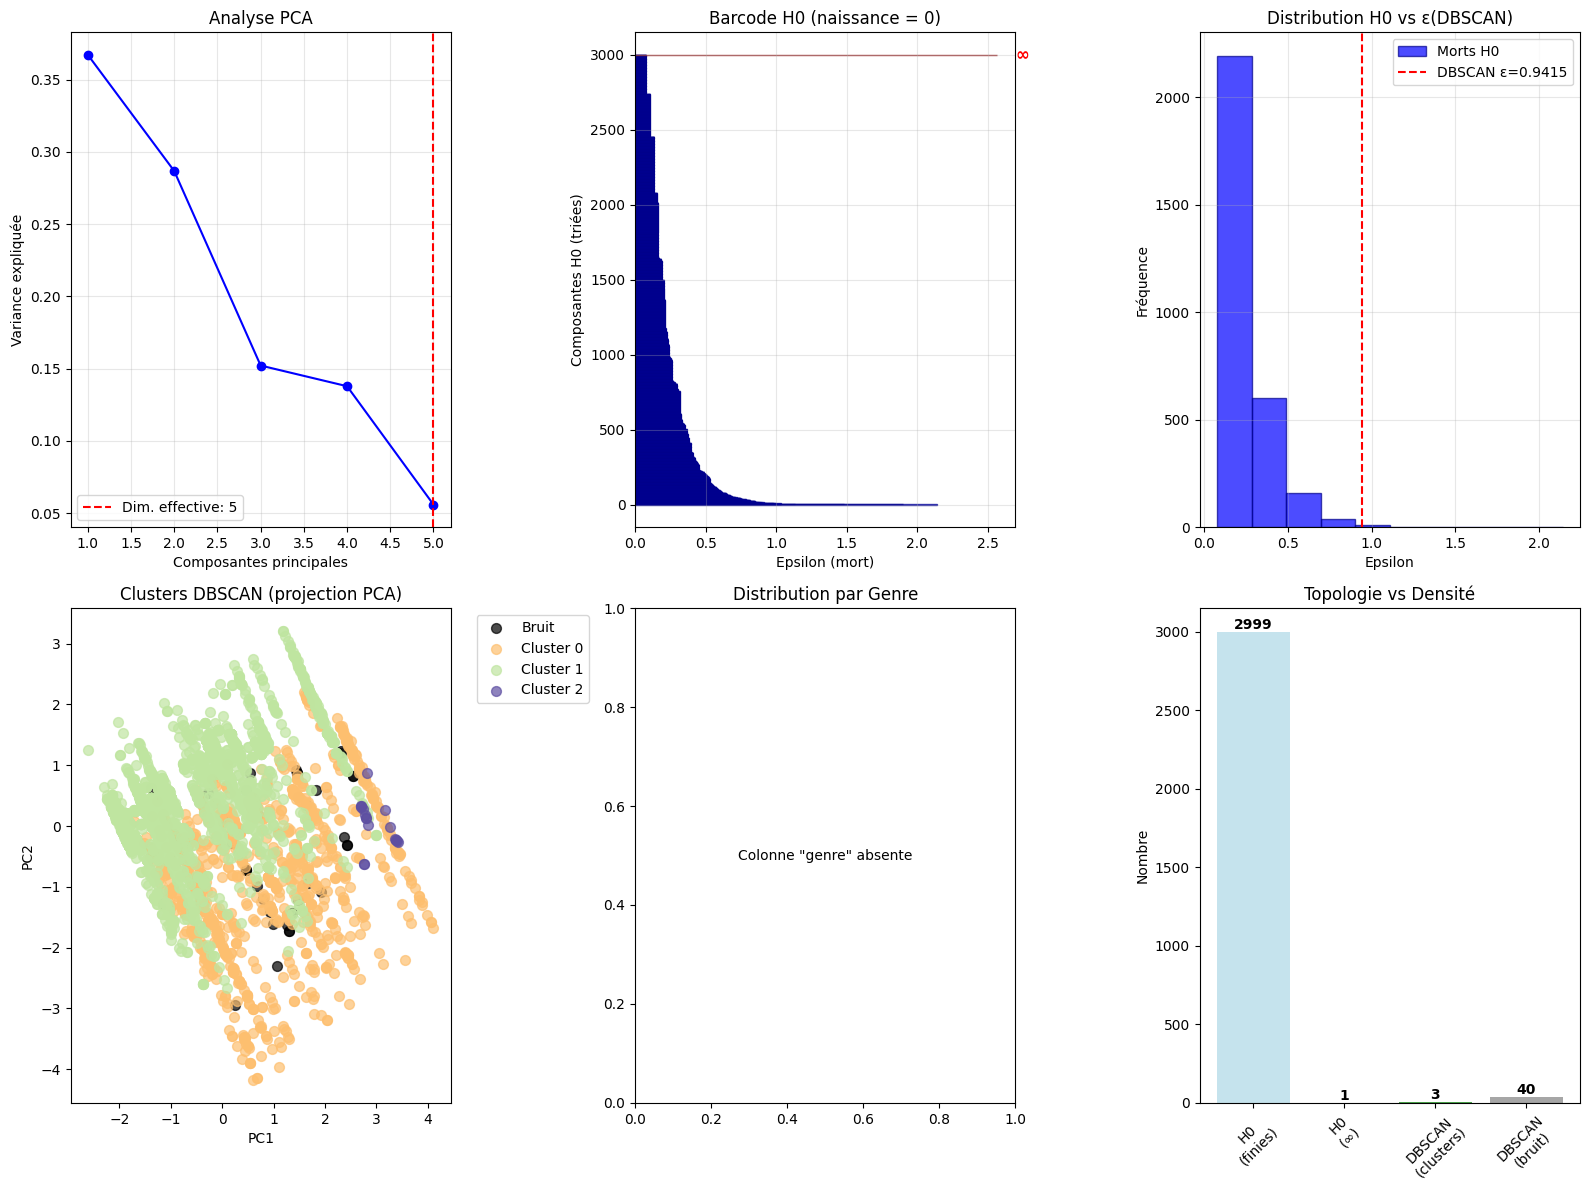


=== RAPPORT DE SYNTHÈSE ===
• Dimension effective: 5/5
• Variance expliquée (95%): 1.000
• H0 - Composantes finies: 2999
• H0 - Composante survivante: 1
• H0 - Epsilon maximal MST: 2.139160
• H0 - Features significatives (~>10% εmax): 1175
• DBSCAN - Clusters (densité): 3
• DBSCAN - Points de bruit: 40
• DBSCAN - Paramètres: eps=0.941481, min_samples=10
• DBSCAN - Silhouette: 0.269
• DBSCAN - Calinski-Harabasz: 497.9
• DBSCAN - Davies-Bouldin: 1.379

=== JUSTIFICATION MÉTHODOLOGIQUE ===
• Persistance H0 via MST k-NN: scalable + monotonie garantie
• Toutes les barres H0 naissent à ε=0 (Vietoris-Rips euclidien)
• DBSCAN optimisé: k-distance + dimension effective + garde-fous
• Séparation sémantique: H0=topologie, DBSCAN=densité+bruit
• Validation croisée: cohérence structures topologiques vs clusters


In [48]:
analyzer = analyze_harmonic_tda(X_scaled, df_sample, available_features, scaler)